# Notebook for Analysis of Parameter Effects on Trading Frequency

Thie notebook serves to provide a platform to test the effects of each of the parameters of the developed strategy on the trading frequency. In particular, we study the effects of the moving average period and the quantile sampled. 

In [1]:
''' Module imports and declarations '''
%matplotlib inline
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from scipy.stats import norm
from matplotlib.pyplot import figure

In [2]:
''' Define a function that fits OUP using linear (least-squares regression) '''
def lin_fit_OUP(price_history, T=1, steps=200):
    
    # Estimate the parameters using the methods used in the literature
    n = len(price_history) - 1
    np_stock = np.array(price_history)
    
    Sx = sum(price_history[:-1])
    Sy = sum(price_history[1:])
    Sxx = np.sum(np_stock[:-1] ** 2)
    Sxy = np.sum(np_stock[:-1] * np_stock[1:])
    Syy = np.sum(np_stock[1:] ** 2)

    a = ((n * Sxy) - (Sx * Sy)) / ((n* Sxx) - (Sx ** 2))
    b = (Sy - (a * Sx)) / n
    sde = math.sqrt(((n * Syy) - (Sy ** 2) - (a * ((n * Sxy) - (Sx * Sy)))) / (n * (n - 2)))

    # dX = alpha*(mu-X)*dt + sigma*dW
    delta = T / steps

    # alpha = - ln a / delta
    alpha = - (math.log(a) / delta)

    # mu = b / 1 - a
    mu = b / (1 - a)

    # sigma = sd(epsilon) * sqrt( -2 ln a / delta * (1 - a^2) )
    sigma = sde * math.sqrt((-2 * math.log(a)) / (delta * (1 - a ** 2)))  
    return alpha, mu, sigma

In [3]:
''' 
DISCLAIMER: this code is largely taken from the Numerical Methods for Finance UCL Moodle Page,
          specifically, the OUP MATLAB code as suggested by the project supervisor 
'''

''' Function for generating OUP series '''
def gen_OUP(alpha=5, mu=0.07, sigma=0.07, seed=-1, init_val=0.03, T=1, steps=200, analytic=True):
    
    ################################################
    # alpha, mu and sigma are the model parameters #
    # dX = alpha*(mu-X)*dt + sigma*dW              #
    #                                              #
    # alpha is the mean-reversion strength         #
    # mu is the value of the long-term mean        # 
    # sigma is the volatility of the series        #
    ################################################
    
    # If the seed is set, use it, otherwise generate randomly
    if seed != -1:
        np.random.seed(seed)

    # Store the series
    X = [init_val]
    
    # The initial value is considered the "first step"
    steps -= 1
    
    # Sample standard Gaussian random numbers
    mean = 0
    std  = 1
    N = np.random.normal(mean, std, steps)

    # Calulate the time difference with each step
    dt = T / steps

    ''' The following block is responsible for the actual generation of the OU paths '''
    # Euler with analytic moments
    if analytic:
        # Compute the standard deviation for a time step
        sdev = sigma * math.sqrt((1 - math.exp(-2 * alpha * dt)) / (2 * alpha))
        
        # Compute and accumulate the increments
        for i in range(steps):
            X.append(mu + (X[i] - mu) * math.exp(-alpha * dt) + sdev * N[i])
            
    # plain Euler 
    else:
        sdev = sigma * math.sqrt(dt)                                               
        for i in range(steps):
            X.append(X[i] + alpha * (mu * X[i]) * dt + sdev * N[i])
            
    # Return the generated series
    return X

In [4]:
''' Trade OUP with selected parameters - back-test : MODIFIED TO COUNT TRADES '''
def trade_OUP(stock_price, trading_time=500, ma_period=21, ma_t="ema", T=1, quantile=0.25, plot=False):
    
    # Ensure the parameters are valid
    s_len = len(stock_price)
    assert trading_time + ma_period < s_len, "Trading time with moving average period must be smaller than series length."

    # Keep track of lines for plotting
    top_band = []
    bot_band = []
    ma = []
    
    # Keep track of accumulated profit
    profit_percent = 0
    
    # Current state of trading
    holding = False
    buy_point = None
    
    # Track trade count
    trades = 0
    
    # If the moving average is ema, we need an initial value
    if ma_t == "ema":
        ema = stock_price[s_len - trading_time - ma_period]
        for index in range(s_len - trading_time - ma_period + 1, s_len - trading_time):
            ema = (stock_price[index] - ema) * (2 / (ma_period + 1)) + ema
        ma.append(ema)
    
    # Go through the series and trade OUP
    for point_index in range(s_len - trading_time, s_len):
        
        # Identify the indexes for the start and end of the relevant series
        start = point_index - ma_period + 1
        end = point_index + 1
        
        # Exponential moving average
        if ma_t == "ema":
            ema = (stock_price[point_index] - ma[-1]) * (2 / (ma_period + 1)) + ma[-1]
            ma.append(ema)
        
        # Simple moving average 
        else:
            sma = sum(stock_price[start:end]) / ma_period
            ma.append(sma) 
        
        # Define the rest of the corridor
        try:
            
            # We are looking for the probability distribution at point 'point_index', using the series 
            # of len ma_period before it
            alpha, mu, sigma = lin_fit_OUP(stock_price[start:end], steps=ma_period, T=T)

            # Calculate the probability distribution at this point
            expected = mu + ((stock_price[start] - mu) * math.exp(-alpha * T))
            standard_dev = sigma * math.sqrt((1 - math.exp(-2 * alpha * T)) / (2 * alpha))
            quantiles = norm.ppf([quantile, 0.5, 1 - quantile], expected, standard_dev)
            
            # Calculate the offsets
            top = ma[-1] + (quantiles[2] - quantiles[1])
            bot = ma[-1] - (quantiles[1] - quantiles[0])

        # In the event we cannot perform the fit with least-squares
        except:
            
            # Use the previous offset if we can
            try:
                offset_top = top_band[-1] - ma[-2]
                top = ma[-1] + offset_top
                
                offset_bot = ma[-2] - bot_band[-1]
                bot = ma[-1] - offset_bot
                
            # Otherwise, use offset = 5% of price
            except:
                offset = 0.05 * stock_price[point_index]
                top = ma[-1] + offset
                bot = ma[-1] - offset
        
        # Append the top and bottom regardless of how we generate them
        top_band.append(top)
        bot_band.append(bot)
        
        # Figure out if we need to buy or sell
        if stock_price[point_index] <= bot and not holding:
            holding = True
            buy_point = point_index   
        elif stock_price[point_index] >= top and holding:
            holding = False
            
            # If we sell, accumulate the profit as a percentage
            profit_percent += ((stock_price[point_index] - stock_price[buy_point]) / (stock_price[buy_point])) * 100
            
            # We count a complete trade as a buy followed by a sell
            trades += 1
            
    # Plot everything relevant to trading
    if plot:
        figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')        
        plt.plot(stock_price, label="Asset")
        plt.plot(range(s_len-trading_time, s_len), top_band, label="Top Band")
        plt.plot(range(s_len-trading_time, s_len), bot_band, label="Bottom Band")
        
        # Handle the differences between ema and sma generation
        if ma_t == "ema":
            plt.plot(range(s_len-trading_time, s_len), ma[1:], label="EMA")
        else:
            plt.plot(range(s_len-trading_time, s_len), ma, label="SMA")
        plt.ylim(min(stock_price), max(stock_price))
        plt.xlabel("Observations")
        plt.ylabel("Asset Value")
        plt.legend()
    return profit_percent, trades

	MA:  7
	 0 -1.6321341772363525 34
	 1 5.314948732389892 36
	 2 -6.279926489459127 26
	 3 -13.355264596497383 26
	 4 2.503076297588924 38
	 5 -3.127422325422423 25
	 6 -8.419314590523616 29
	 7 1.9440140563666475 31
	 8 -1.8253768486322994 29
	 9 -4.647773008054417 28
	 10 2.1644229854661416 30
	 11 -4.980885577980937 27
	 12 4.996792860512667 33
	 13 -1.096794429703702 29
	 14 1.0346139640841816 37
	 15 0.23121946069806132 31
	 16 -1.7107908019065112 22
	 17 -4.165922483549499 31
	 18 -7.1278410209892265 30
	 19 -2.352142688779357 28
	 20 -1.9627601598404114 30
	 21 -5.6942432705489905 27
	 22 -4.020687320117539 30
	 23 -4.962090013154755 29
	 24 3.5022840465747347 32
	 25 -1.1923800482032965 32
	 26 1.702354600636691 35
	 27 -2.769611792440517 34
	 28 2.265179885871432 30
	 29 -0.17269702071697876 31
	 30 2.711317879053741 37
	 31 -4.981695103556191 26
	 32 0.12989587412587406 25
	 33 -1.5612054143359382 33
	 34 0.4434441925249581 26
	 35 3.685008868938801 33
	 36 7.229415862036424 3

	 7 7.787075350769153 9
	 8 4.7381404654779 7
	 9 -1.0306720544061405 7
	 10 7.47512193260717 8
	 11 -2.6048267676379084 1
	 12 5.322479478116589 7
	 13 -1.727844700643774 2
	 14 -6.9941601937353886 3
	 15 2.762730393184955 5
	 16 2.2301253688242815 5
	 17 -3.4898113547604304 1
	 18 -7.975192739186653 3
	 19 0.552657730518982 6
	 20 0.4546971348288844 2
	 21 -1.5042650222677207 4
	 22 2.243558829277489 3
	 23 -4.890690381257816 2
	 24 0.29054480979316866 4
	 25 1.8586954473206236 7
	 26 1.359410277994885 4
	 27 1.4410925482229193 3
	 28 3.6724292534267304 7
	 29 1.6115635071250047 5
	 30 -1.526880240015558 5
	 31 -2.249091581161389 3
	 32 0.4459664147365352 4
	 33 -4.050573137744616 2
	 34 8.363509165446438 6
	 35 3.7220585601506837 7
	 36 1.8838590166393696 6
	 37 5.432483582361866 6
	 38 1.7862400543868158 4
	 39 3.143627127592668 4
	 40 3.090029243332311 6
	 41 3.2047296199340902 5
	 42 -8.464951760386754 4
	 43 -0.40210455633346864 5
	 44 -7.501399309586752 3
	 45 -2.88672161059446

	 37 5.608356940590538 3
	 38 3.2033732927492258 2
	 39 4.989651250274211 3
	 40 1.3719602416455579 2
	 41 1.9306881384322094 2
	 42 1.7795679571734557 1
	 43 2.6160319669041474 3
	 44 0 0
	 45 -1.549366748729115 2
	 46 3.8698084750596218 6
	 47 4.511341467694551 3
	 48 -3.3849535208250456 2
	 49 1.8631562654797804 3
	 50 4.414757308777373 3
	 51 6.141812503285037 4
	 52 -9.400462774437816 1
	 53 3.470484184811953 4
	 54 3.9616129342877167 2
	 55 2.2404122730214695 2
	 56 2.719098749104867 2
	 57 -0.032092621066035935 1
	 58 2.52070592372357 4
	 59 1.681987409938409 1
	 60 2.690829331274396 1
	 61 3.456044187054072 3
	 62 4.55970604054244 6
	 63 2.190200095796217 2
	 64 5.533893958889333 4
	 65 4.344189670857628 4
	 66 6.226972692727842 4
	 67 3.177286742538527 3
	 68 4.501561673735544 4
	 69 2.3381311733500763 4
	 70 0 0
	 71 6.554462868099996 3
	 72 -1.6922184558159585 2
	 73 2.810905274096278 2
	 74 4.6995545548038775 2
	 75 3.039254781431847 2
	 76 2.5289952776712528 2
	 77 0 0
	 7

	 85 6.808483552836659 4
	 86 4.361217856683835 2
	 87 2.539997029801701 2
	 88 0 0
	 89 1.3293967990147577 1
	 90 2.182410645110131 1
	 91 1.7070383375713734 1
	 92 3.486760915157716 2
	 93 0 0
	 94 0 0
	 95 1.549769613731055 1
	 96 1.3874018296602153 1
	 97 5.275456313621486 2
	 98 2.655439705880963 1
	 99 1.2897706443598196 1
	MA:  7
	 0 3.246541605448387 30
	 1 -2.651754264360963 32
	 2 -4.187184400076252 28
	 3 -2.470367564161342 27
	 4 3.7366765507283195 33
	 5 -2.0436232704451545 29
	 6 -5.557701145580511 24
	 7 0.5866235018424771 31
	 8 0.2508150157048051 33
	 9 3.1044145817822573 38
	 10 -0.1936338107681786 33
	 11 -5.793536365198138 28
	 12 6.318973185486492 42
	 13 -0.8182651696650695 34
	 14 2.3290424204181246 33
	 15 -3.00720628553516 29
	 16 8.206891102576868 42
	 17 -1.6101677190629786 27
	 18 6.36048788619828 31
	 19 0.6894603836609395 36
	 20 0.134106272614681 29
	 21 -3.611822986297076 29
	 22 3.2881509472498105 33
	 23 9.383717831904226 33
	 24 -9.84422537539741 28
	

	 96 3.6000652886374596 7
	 97 -1.2056661967290903 8
	 98 2.5478764537919045 8
	 99 5.646527739063208 13
	MA:  100
	 0 3.1887803809590474 4
	 1 2.786674188688518 6
	 2 6.550593875828554 8
	 3 3.1447761768623246 3
	 4 0.5574333153568416 5
	 5 6.243941453871442 8
	 6 -5.191936429964866 3
	 7 3.0490552584117045 3
	 8 0.18429858785433062 5
	 9 4.543534594785447 4
	 10 -0.7157274899943644 3
	 11 -0.060819247992224046 4
	 12 -0.4630470377857039 4
	 13 0.6978505546690241 7
	 14 1.7621979586147827 9
	 15 -1.016842100280281 3
	 16 3.38425417055329 5
	 17 1.4263880829834803 4
	 18 8.788843602847148 7
	 19 -0.5277379994655766 2
	 20 5.614123551656943 7
	 21 -2.2957715880302216 4
	 22 2.5205153158033053 4
	 23 7.422981052178082 9
	 24 -2.450918922783764 2
	 25 0.021578695293291705 7
	 26 3.074868591713359 4
	 27 -3.2088470004536034 2
	 28 2.0652684786957396 4
	 29 9.860608447001766 10
	 30 -1.5226449869535847 2
	 31 1.6778071552992582 4
	 32 2.2167029032301397 6
	 33 3.073590668478928 4
	 34 7.476

	 18 10.48654360599411 5
	 19 2.8609397117097286 2
	 20 2.2024898993507147 3
	 21 0 0
	 22 8.089346210860864 3
	 23 3.2269728933270705 2
	 24 1.3210924925704244 1
	 25 0.47798695057051854 2
	 26 1.982714540801582 2
	 27 0.6625051998155199 2
	 28 3.6601803263599555 3
	 29 8.772945593835361 6
	 30 0.9622219445107321 1
	 31 3.8886340380704945 3
	 32 1.5668897772255348 2
	 33 3.93857826284459 2
	 34 6.313370551834158 4
	 35 -2.8980921359755523 3
	 36 -2.3960768046147374 1
	 37 0 0
	 38 0.7342540573053997 2
	 39 -0.21068017656621565 1
	 40 8.1316842870099 6
	 41 -2.3893482782032507 1
	 42 4.177030899220559 3
	 43 1.7092682407113955 2
	 44 0 0
	 45 -1.4036297765986918 1
	 46 5.649218261877655 4
	 47 -4.183026107254885 1
	 48 0.9802994119053493 1
	 49 3.2350012696075146 3
	 50 3.1770649294047635 3
	 51 -0.021881394381329834 1
	 52 2.2729848870988913 2
	 53 2.452595467577297 3
	 54 8.165338873293777 6
	 55 5.374100652111214 4
	 56 2.2821626117337654 2
	 57 2.0764530058604582 2
	 58 0 0
	 59 -1

	 60 7.399850260077505 4
	 61 4.253617843987388 3
	 62 4.917156408997804 2
	 63 5.447630094464269 3
	 64 1.9926783973449984 1
	 65 3.055414703649201 2
	 66 4.697260089966356 4
	 67 6.168377978318059 2
	 68 3.0359344552690213 2
	 69 -5.2292570563600504 1
	 70 3.5356248710593148 2
	 71 2.0511171229759437 1
	 72 1.511997835034863 1
	 73 2.6448689052810974 1
	 74 8.438045479175573 5
	 75 1.4255231705844247 1
	 76 8.336298604553004 3
	 77 6.588272435459949 4
	 78 0 0
	 79 0 0
	 80 5.777188011186001 3
	 81 0 0
	 82 2.253423280368113 2
	 83 3.2213580262758916 2
	 84 2.1461827452806648 1
	 85 2.6519753424973653 3
	 86 3.701469879456032 3
	 87 0.046144755907002656 1
	 88 1.7799110779110523 1
	 89 -3.731666942149597 1
	 90 2.640037833933183 2
	 91 -0.6033913996463858 1
	 92 -1.712307768318043 1
	 93 2.978525588892385 1
	 94 1.4218879822764203 1
	 95 4.8881167166707735 3
	 96 5.031063869239836 2
	 97 1.8524329731479856 2
	 98 0 0
	 99 1.2520473353296913 1
	MA:  7
	 0 0.21040713985353432 24
	 1 8.

	 71 -6.059104056752803 7
	 72 -0.027800057959028845 9
	 73 8.482774993964538 15
	 74 -2.676022310297066 8
	 75 4.094686579347048 9
	 76 -10.189579187883993 5
	 77 2.3385260456548007 9
	 78 5.042737836574411 13
	 79 -3.5396243710759903 7
	 80 -2.990805444159723 6
	 81 -4.61305091813319 5
	 82 6.8412782153739595 11
	 83 -6.786857933383986 5
	 84 -5.510030725299237 6
	 85 6.8669771572874545 11
	 86 2.456124453963569 7
	 87 1.5980029789226298 9
	 88 3.6708804415747847 7
	 89 4.502432516979522 9
	 90 -0.7027318505655662 7
	 91 5.521712361803232 10
	 92 1.5800589116086043 7
	 93 -1.105470880539605 8
	 94 3.6097031327533053 6
	 95 6.282104687677418 10
	 96 5.779787514468747 12
	 97 -1.7339319840530472 8
	 98 -3.3292727037770433 5
	 99 0.6013797411819087 8
	MA:  100
	 0 2.19111167769562 2
	 1 5.453841235615375 6
	 2 -0.971882468925233 6
	 3 -0.4562601530942574 4
	 4 -0.09725371916468009 3
	 5 0.30652037406649324 3
	 6 -0.2323644245566736 4
	 7 -0.5017153215431456 4
	 8 5.935402711580793 8
	 9

	 93 0.647822815302257 3
	 94 2.553403229324377 2
	 95 3.6505013913715882 4
	 96 7.009122763867627 7
	 97 1.747961169612032 2
	 98 4.174375481550134 3
	 99 -0.4669973029940788 3
	MA:  250
	 0 1.6266402827259385 1
	 1 1.984910088653146 2
	 2 -3.3027870197297653 1
	 3 -1.1420522380588571 2
	 4 3.4520978706925165 2
	 5 2.408948485289131 2
	 6 5.016791425107972 4
	 7 -0.27596103969290375 2
	 8 5.698682584558872 5
	 9 1.1084663053150385 2
	 10 2.5838450899687233 2
	 11 1.3824224651983312 1
	 12 6.023163643900503 4
	 13 6.6262235231750575 4
	 14 2.120411787812262 2
	 15 1.5694154216597798 1
	 16 0.9473962546628203 1
	 17 5.188492496537906 4
	 18 4.135376485113485 3
	 19 0 0
	 20 5.858166034182216 4
	 21 3.1899358605999915 2
	 22 1.243964172142557 1
	 23 2.4603319403628063 2
	 24 -1.4715145032071597 2
	 25 5.763558750029707 4
	 26 3.932900137073264 3
	 27 4.4638140229335495 3
	 28 -0.2722338657646257 3
	 29 1.27905530747748 1
	 30 1.5334037914993701 4
	 31 3.6425907866916987 3
	 32 1.32738519

	 34 2.6635350535139457 1
	 35 1.591113278554732 1
	 36 -0.13027650347098452 2
	 37 1.802412064964596 1
	 38 1.9481249433587817 1
	 39 0.4628373329468105 2
	 40 1.5069511413985277 1
	 41 0 0
	 42 4.539602229825387 1
	 43 3.4680343569224004 1
	 44 6.485941751246907 2
	 45 7.352935527939371 2
	 46 0 0
	 47 0 0
	 48 0 0
	 49 -0.6802991582312293 1
	 50 1.2535231950980326 1
	 51 0.3335654579020533 1
	 52 1.8800250227642468 2
	 53 0 0
	 54 2.1090419733553363 2
	 55 1.551601144452504 2
	 56 1.560713948090556 1
	 57 2.9085030488153802 2
	 58 1.5261681575441615 1
	 59 6.092364947642549 2
	 60 8.470049188693725 1
	 61 2.7978996005238654 2
	 62 2.6683756595824546 1
	 63 2.56330503643791 2
	 64 7.02184265940592 1
	 65 0 0
	 66 2.687868163970742 1
	 67 2.612517600482626 2
	 68 5.671013119316766 3
	 69 -1.3149875693262576 1
	 70 0 0
	 71 0 0
	 72 0 0
	 73 3.1423339918409923 2
	 74 4.446927088767275 3
	 75 4.834278074628059 4
	 76 0 0
	 77 4.354288938723871 3
	 78 1.5821651451865058 1
	 79 1.58307922

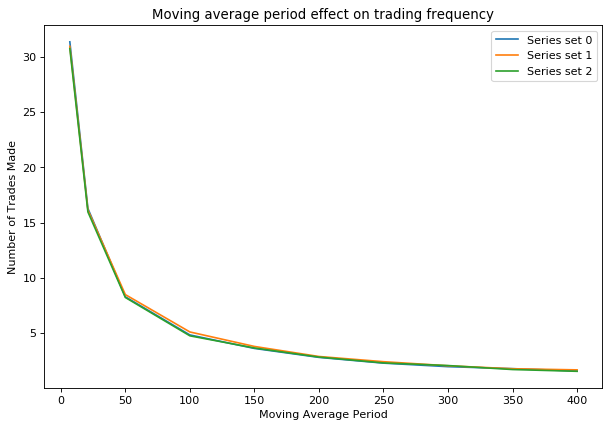

In [5]:
''' Measure the effects of the moving average period on the trading frequency '''
# Used to add size and clarity to the graph we create
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k') 

# For 3 sets of 100 OUP paths, calculate the average number of trades made with some moving average
for n in range(3):
    assets = []
    for i in range(100):
        asset = gen_OUP(alpha=1, mu=100, init_val=100, sigma=10, steps=1000)
        assets.append(asset)

    # Test across these moving averages
    MAS = [7, 21, 50, 100, 150, 200, 250, 300, 350, 400]
    line = []
    for MA in MAS:
        print("\tMA: ", MA)
        trades = []
        
        # Average the number of trades completed with these parameters
        for i in range(len(assets)):
            
            # We select a fixed quantile, 0.3, to measure just the effects of the period
            profit, trade = trade_OUP(assets[i], ma_period=MA, quantile=0.3)
            trades.append(trade)
            print("\t", i, profit, trade)
        avg = sum(trades)/len(trades)
        line.append(avg)
    plt.plot(MAS, line, label="Series set " + str(n))

# Plot the rest of the graph and add labels
plt.xlabel("Moving Average Period")
plt.ylabel("Number of Trades Made")
plt.legend()
plt.title("Moving average period effect on trading frequency")
plt.show()

	Quant:  0.1
	 0 2.952713456314764 3
	 1 -3.520805272310228 2
	 2 7.678606368224901 6
	 3 2.501590958266572 5
	 4 -1.9560227855520806 3
	 5 7.163626482013253 6
	 6 2.5516881030398064 4
	 7 -2.8286865307267908 4
	 8 -2.594753944672963 3
	 9 2.3448478475927366 3
	 10 4.488620699372929 5
	 11 -0.2578377962542111 4
	 12 -12.89393858921812 3
	 13 2.488107343426321 1
	 14 -1.4605169652286942 2
	 15 1.7283816638589946 5
	 16 8.007057027118355 5
	 17 5.008450786565284 4
	 18 1.0270672785271455 2
	 19 1.693910762627805 3
	 20 2.1904949261144604 5
	 21 6.100307214030396 6
	 22 8.00380291262033 6
	 23 -2.1443475208065763 4
	 24 -5.840062997781597 4
	 25 -1.55610426310081 2
	 26 1.6914400212571734 1
	 27 -0.059144266811677726 3
	 28 2.274601553718474 4
	 29 4.349483335279775 4
	 30 0.04847950026351677 3
	 31 -7.180077429636431 3
	 32 -1.7437614216110109 1
	 33 5.50858612606773 3
	 34 0.46684334400843436 3
	 35 5.341009949111768 5
	 36 2.043495881370653 3
	 37 -1.026393390805388 4
	 38 1.9569874805

	 17 6.841151574760884 16
	 18 7.242439180738692 16
	 19 4.311244033590474 13
	 20 0.6889496143082279 15
	 21 1.0975151480245096 17
	 22 7.63400359749557 19
	 23 1.0671723401178284 14
	 24 -7.130510545602996 12
	 25 1.784790990386314 13
	 26 3.4472517002917087 8
	 27 0.10461057852949984 11
	 28 2.9001363307332793 16
	 29 7.129261398311662 19
	 30 3.7413083162339795 14
	 31 -4.005566371467211 15
	 32 2.986311718535673 10
	 33 2.2859386239764588 12
	 34 -0.9054123630917587 11
	 35 4.889859124663838 13
	 36 -1.921549713794134 9
	 37 -2.8705909521943074 10
	 38 5.8553642302495374 15
	 39 0.2638185917034158 12
	 40 4.358815847464685 14
	 41 0.8545370596967652 11
	 42 4.057712715513045 13
	 43 2.216793898134214 15
	 44 -0.6432950419246146 9
	 45 1.53802892102111 13
	 46 3.2240082492779454 12
	 47 -0.9982710374058597 10
	 48 0.8638251570972594 11
	 49 -0.8606824836152507 10
	 50 5.490009089144587 18
	 51 3.9275565380181074 10
	 52 -1.2688547509764898 14
	 53 6.408857899044846 18
	 54 -1.35498

	 31 2.728656277352892 5
	 32 -0.24576772484231502 7
	 33 -0.42075543721582376 6
	 34 -0.6714186197939429 6
	 35 -0.4477257384229204 6
	 36 -6.8418776949606 9
	 37 6.971902656529334 11
	 38 8.740664642250316 13
	 39 -0.6303043145752848 7
	 40 1.3672162436951245 7
	 41 6.909912802024098 8
	 42 -0.4039310617118021 4
	 43 -0.5373605769294743 9
	 44 -11.288532572530086 4
	 45 6.652297573076176 12
	 46 0.9916644144773846 7
	 47 -2.5895897691431493 6
	 48 8.8049273013342 15
	 49 1.397617535797263 12
	 50 3.6823151409016015 12
	 51 2.7688219757278683 11
	 52 -2.3763288432829954 7
	 53 3.858501410166835 10
	 54 -0.46522547259532443 8
	 55 -1.0660051990935404 11
	 56 3.770427063632964 9
	 57 -0.7746136818612337 10
	 58 1.8317082055254863 10
	 59 -2.3841997971554054 6
	 60 1.3064113005217433 13
	 61 3.222090910426796 11
	 62 3.414885497128439 6
	 63 -1.1979924582511234 10
	 64 3.656813284835794 11
	 65 2.7726939937281325 10
	 66 3.424348613811526 8
	 67 -2.747360942332575 10
	 68 3.1404431667492

	 46 -0.305624808183814 6
	 47 0.061106835154718375 6
	 48 2.7912219665425404 5
	 49 8.89797293023016 10
	 50 -8.187248209250148 4
	 51 5.5331190151924465 8
	 52 5.131900573708713 5
	 53 -4.299750698512434 5
	 54 -7.488434421547467 4
	 55 3.4245609248953564 7
	 56 -0.7396580164902149 5
	 57 -2.1481702624388346 8
	 58 -0.042515628978311626 6
	 59 -0.23924280945219017 5
	 60 2.2091973968199747 8
	 61 4.17638370557279 5
	 62 8.875976856984547 9
	 63 3.2299332983038114 8
	 64 -5.412527813966621 5
	 65 6.298857804335862 12
	 66 -4.36065588819329 4
	 67 2.2249909661077854 8
	 68 -0.93831957421515 4
	 69 5.207482561989821 8
	 70 4.400315321976712 7
	 71 0.2647376867930824 6
	 72 3.902931624308246 6
	 73 0.9338289636386419 4
	 74 6.056239108724562 7
	 75 -2.3045362251662533 6
	 76 4.259731263610406 6
	 77 4.406936789386913 8
	 78 -0.8984490850860716 6
	 79 -2.1483948383042524 6
	 80 2.4151258208535884 4
	 81 5.410713084253359 6
	 82 -9.349299310697361 3
	 83 7.295090328548883 10
	 84 -0.131757

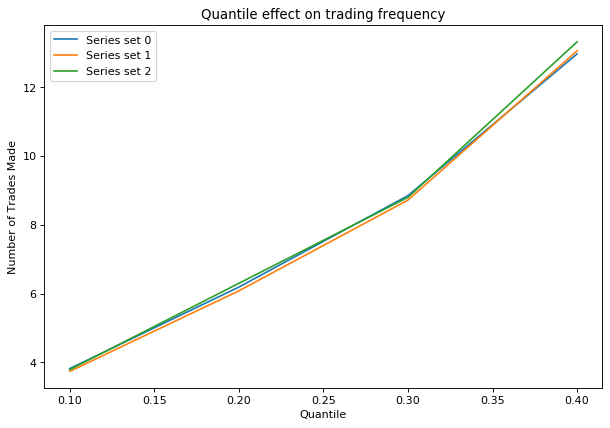

In [6]:
''' Measure the effects of the sampled quantile on the trading frequency '''
# Repeat the above block, but this time we alternate the value of the quantile
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k') 
for n in range(3):
    assets = []
    for i in range(100):
        asset = gen_OUP(alpha=1, mu=100, init_val=100, sigma=10, steps=1000)
        assets.append(asset)
    QUANTS = [0.1, 0.2, 0.3, 0.4]
    line = []
    for Q in QUANTS:
        print("\tQuant: ", Q)
        trades = []
        for i in range(len(assets)):
            
            # Maintain a fixed moving average period to gauge quantile effects
            profit, trade = trade_OUP(assets[i], ma_period=50, quantile=Q)
            trades.append(trade)
            print("\t", i, profit, trade)
        avg = sum(trades)/len(trades)
        line.append(avg)
    plt.plot(QUANTS, line, label="Series set " + str(n))
plt.xlabel("Quantile")
plt.ylabel("Number of Trades Made")
plt.legend()
plt.title("Quantile effect on trading frequency")
plt.show()